In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/data science/mercari price prediction")

In [3]:
cwd= os.getcwd()
print(cwd)

/content/drive/MyDrive/data science/mercari price prediction


In [4]:
!p7zip -d train.tsv.7z
!p7zip -d test_stg2.tsv.zip

/usr/bin/p7zip: cannot read train.tsv.7z
/usr/bin/p7zip: test_stg2.tsv.zip: unknown suffix


Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from tqdm import tqdm
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

Data collection



In [6]:
train = pd.read_csv('train.tsv', sep='\t')

In [7]:
test = pd.read_csv('test_stg2.tsv', sep='\t')

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [10]:
train.shape

(1482535, 8)

In [11]:
test.shape

(3460725, 7)

Dataset contains around 1482535 datapoints and 8 features.Features are

    train_id : Unique Id to identify a Data Point
    name : Name of the Product in short
    Item_condition_id: It is an ordinal feature ranging between 1-5,1 being best and 5 worst.
    Category_Name : The Category under which the Product falls into. It is in a hierarchical form of 3 subcategories.It is also a text feature.
    Brand Name : Name of the Brand the Product belongs to
    Price : The Price of the Product
    Shipping : A boolean variable indicating whether the Shipping price will be paid by seller or buyer
    Item Description : A text summary describing the product in much detail.

We can see that some features have NaN values like brand and also in item_description missing is shown by "No description yet".Let's check which all features have NaN values and how many.


In [12]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

So the columns category_name,brand_name and item_description have NaN values.Category_name has 6327 missing values and brand_name has around 6 lakh 32 thousand missing features.item_description has 4 NaN values. Also we have noticed above that item_description has "no description yet",lets see how many datapoints have this value as item_description.

In [13]:
no_description= (train['item_description']=='No description yet').sum()
print(no_description)

82489


So 82489 datapoints have "no description yet" and 4 have NaN values,thus 82493 have no values in item_description.Let's start with feature wise EDA.

#**EDA on Price**



In [14]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Some items are price 0 which might cause some error.Also  75% of the items are price below  29 dollars so most of the items are priced less and few items are price very high as maximum is $ 2009.Let's plot its pdf and see its description.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


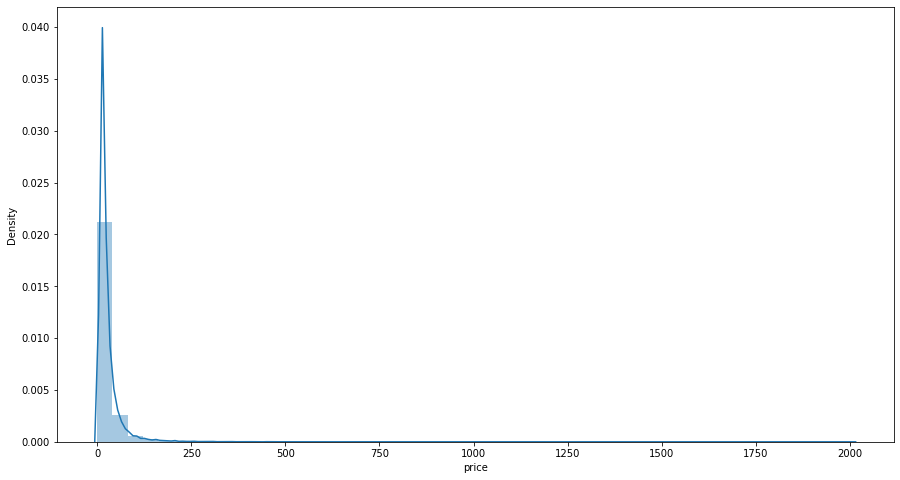

In [15]:
plt.figure(figsize=(15,8))
sns.distplot(train['price'])
plt.show()

We can see that the distribution of price is right skewed and most of the values are less than 100.We also know know that 75 percent of the prices have value less than 29 dollars but the maximum is 2009 dollars,lets see how many items have very high prices.

In [16]:
for i in range(75,101):
  print(np.percentile(train['price'],i))

29.0
30.0
31.0
31.0
33.0
34.0
35.0
36.0
38.0
39.0
40.0
42.0
44.0
46.0
49.0
51.0
55.0
58.0
62.0
67.0
75.0
85.0
99.0
122.0
170.0
2009.0


We can see that 99 percent of items have price less than 170 dollars but the maximum is 2009 dollars,lets dig further.

In [17]:
for i in range (990,1001):
  print(np.percentile(train['price'],i*0.1))

170.0
180.0
189.0
200.0
210.0
230.3300000000745
256.0
286.0
340.0
450.0
2009.0


Thus we can say that 99.9 percent items have price less than 450 dollars,lets dig in further


In [18]:
for i in range(9990,10001):
  print(np.percentile(train['price'],i*0.01))

450.0
459.0
490.0
509.0
556.0
603.1990000000224
659.9864000000525
734.0
838.479600000428
1015.0
2009.0


So 99.99 percent point are less than 1015,for it would be better to remove the points which are price higher than 2000 as they are outliers and Mercari also does not allow items to be priced above 2000 dollars.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


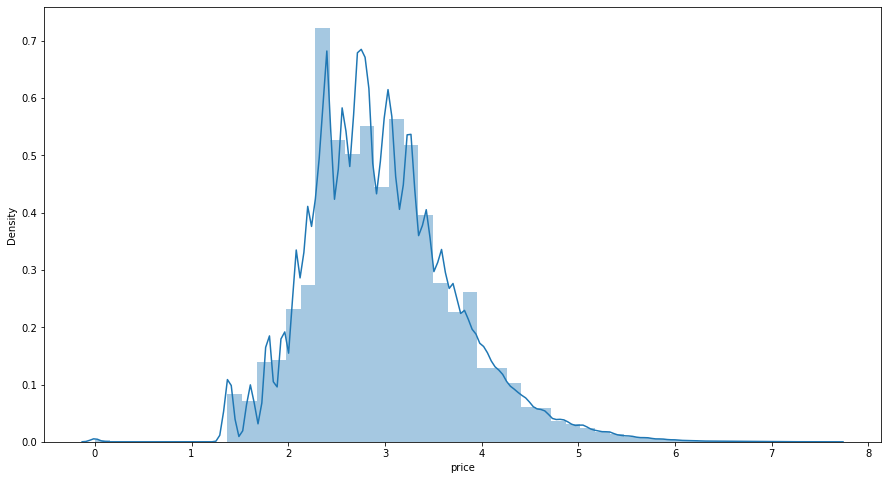

In [19]:
plt.figure(figsize=(15,8))
sns.distplot(np.log(train['price']+1))
plt.show()

We can see that the distribution of np(log['price']+1) is similar to a normal distribution which would also be useful in future,also because metric used in kaggle is RMSLE.We can also see in the graph that there is spike at zero thus there are items with zero prices.Lets check how many items have price less than zero and zero.

In [20]:
negative_price= len(train[train['price']<0])
print("Number of items which have negative prices are: ",negative_price)
zero_price= len(train[train['price']==0])
print("Number of item which are priced zero are: ",zero_price)

Number of items which have negative prices are:  0
Number of item which are priced zero are:  874


Thus there are no item with negative prices but 874 items have price equal to zero.It is also known from research that range of price allowed in Mercari is between 5 dollars to 2000 dollars.Lets check how many values don't fit in this range.

In [21]:
price_less_than_range=len(train[train.price<=5])
price_greater_than_range=len(train[train.price>2000])
not_inrange_prices=price_less_than_range + price_greater_than_range
print("Number of items whose prices are not in range are: ",not_inrange_prices)

Number of items whose prices are not in range are:  67221


These item which have prices that are not within the range allowed can be removed as they are outliers.

#**EDA on item_condition**

It is an ordinal feature indicatating the condition of item where 1 represents that item is in good condition and it gets poor as condition values goes from 1 to 5



In [22]:
train['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


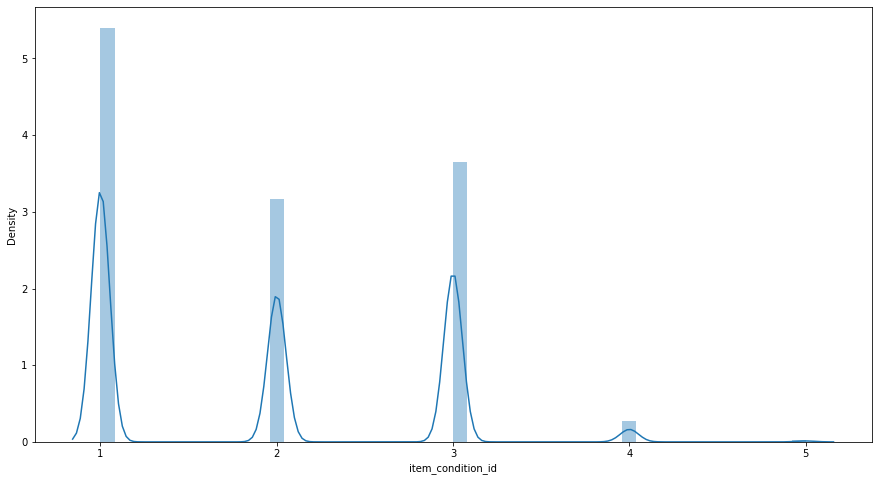

In [23]:
plt.figure(figsize=(15,8))
sns.distplot(train.item_condition_id)
plt.show()

It is clear that item with condition_id=1 occur the most and items with condition_id=5 occur the least

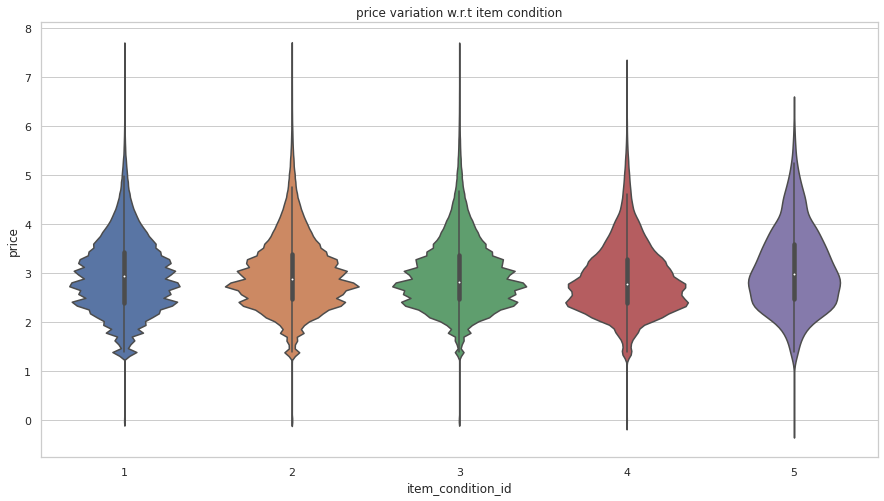

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.violinplot(x=train.item_condition_id,y=np.log(train.price+1))
plt.title("price variation w.r.t item condition")
plt.show()

It can be observed that the aveage prices of all conditions is almost same,item with high prices usually belong to category 1,2 and 3 and items with lowest prices belong to category 5.

#**EDA on Brand_name**

Shows the name of brand the item is of

---



---


MOst of the data points have "NaN" as brand_name



In [25]:
#lets check what percent of items have "NaN" brand names
count_nobrand= train['brand_name'].isnull().sum()
per_nobrand= (count_nobrand/train['brand_name'].shape[0])*100
print("Number of points which do not have brand name: ",count_nobrand)
print("Percentage of points which do not have brand name: ",per_nobrand)

Number of points which do not have brand name:  632682
Percentage of points which do not have brand name:  42.675687251902986


The no of unique brand are:  4809


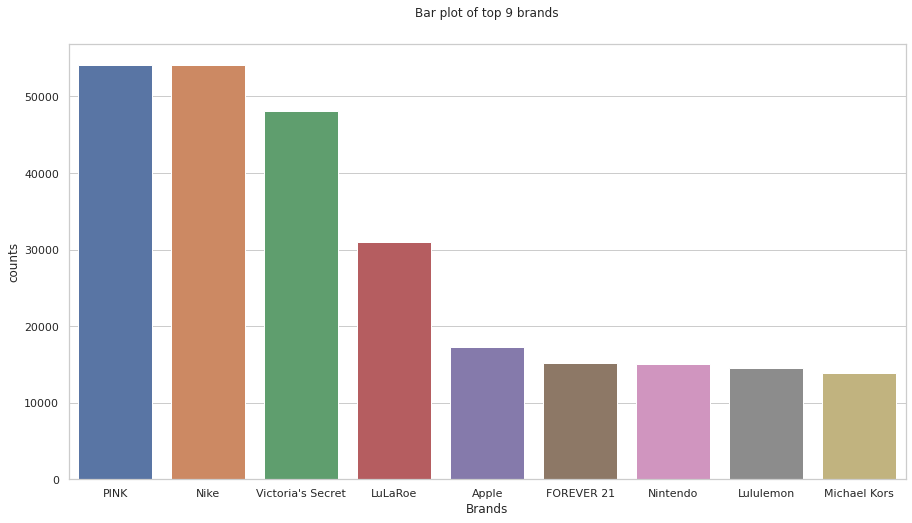

In [26]:
count= train['brand_name'].value_counts()
print("The no of unique brand are: ",len(count))
plt.figure(figsize=(15,8))
sns.barplot(x=count.index[0:9],y=count[0:9])
plt.title('Bar plot of top 9 brands', y=1.05)
plt.xlabel('Brands')
plt.ylabel('counts')
plt.show()


There are 4809 unique brandsand top brands are pink and nike,although around 63 thousand items do not have brands,lets first check distribution of price between these brands and then price distribution between branded and unbranded products.


In [27]:
brand_df=pd.DataFrame((train.groupby('brand_name', as_index=False)).mean())

In [28]:
#Table of Brand Name along with the Average Price Per Brand
print(brand_df.shape)
brand_df[['brand_name','price']].head(10)

(4809, 5)


,brand_name,price
0,!iT Jeans,16.000000
1,% Pure,16.344262
2,10.Deep,17.333333
3,191 Unlimited,36.000000
4,1byone,51.000000
5,21men,12.166667
6,24/7 Comfort Apparel,47.000000
7,2K Games,9.000000
8,2XU,32.000000
9,3.1 Phillip Lim,141.619048


In [29]:
#filling missing brand values as "missing"
train['brand_name'] = train['brand_name'].fillna('missing').astype('category')
print(train.brand_name.isnull().sum())

0


In [30]:
count_unbranded=train[train['brand_name']=="missing"]
count_branded=train.loc[train['brand_name']!="missing"]

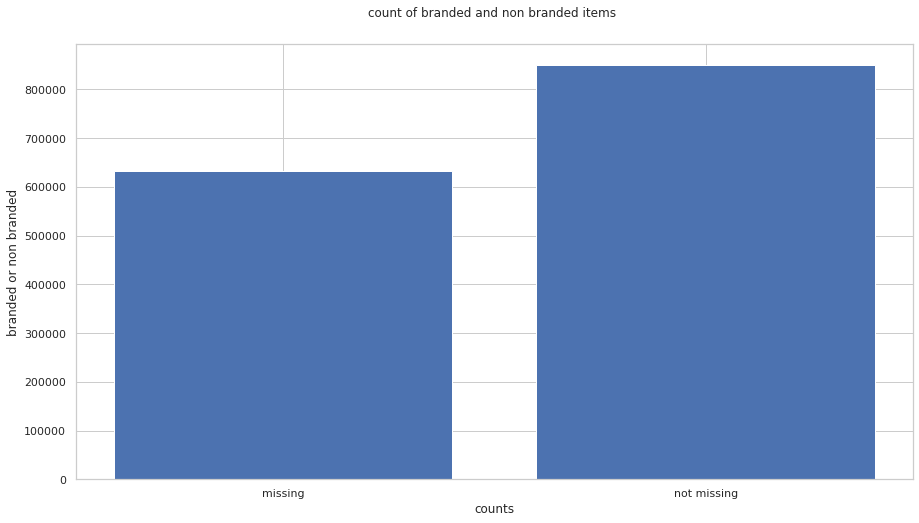

percentage of branded items:  57.32431274809701
percentage of unbranded items:  42.675687251902986


In [31]:
brand_data={"missing":count_unbranded.shape[0],"not missing":count_branded.shape[0]}
keyy=list(brand_data.keys())
values=list(brand_data.values())

plt.figure(figsize=(15,8))

plt.bar(keyy,values)
plt.xlabel("counts")

plt.ylabel("branded or non branded")
plt.title('count of branded and non branded items ' , y=1.05)
plt.show()

print('percentage of branded items: ', (count_branded.shape[0]/train.shape[0])*100)
print('percentage of unbranded items: ', (count_unbranded.shape[0]/train.shape[0])*100)

There are more items with known brands than unknown brands

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


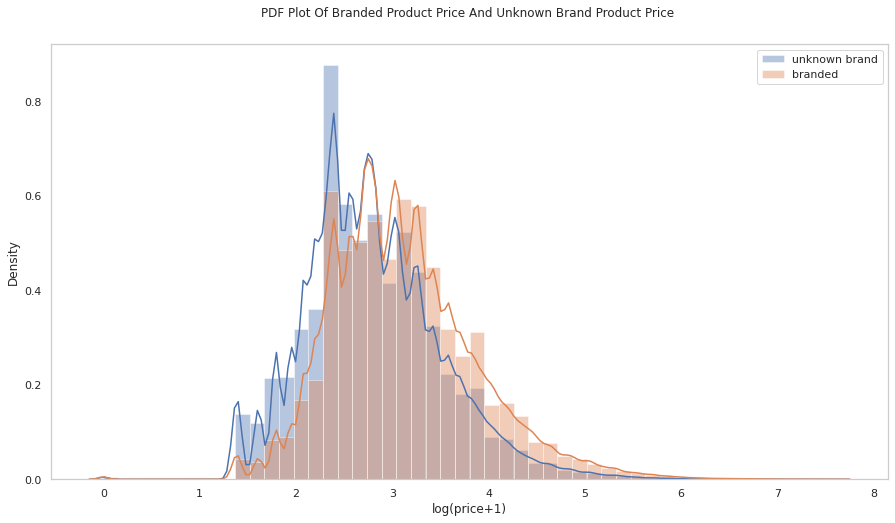

In [32]:
plt.figure(figsize=(15,8))
sns.distplot(np.log(count_unbranded['price']+1),label="unknown brand")
sns.distplot(np.log(count_branded['price']+1),label="branded")
plt.title('PDF Plot Of Branded Product Price And Unknown Brand Product Price ',y=1.05)
plt.xlabel('log(price+1)')
plt.grid()
plt.legend()
plt.show()

Price of item whose brand is known is greater than of those whose brand is not known.So it goes with the intuition that branded items are usually costlier than unbranded item.


##EDA on Shipping

It is a boolen feature which indicates who pays shipping cost

    0 : buyer pays for shipping
    1 : seller pays for shipping



In [33]:
count=train['shipping'].value_counts()
count

0    819435
1    663100
Name: shipping, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


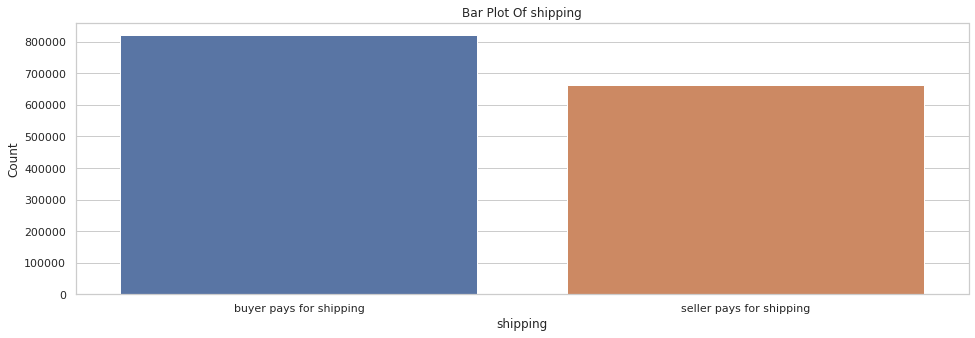

In [34]:
plt.figure(figsize=(16,5))
count.index=('buyer pays for shipping','seller pays for shipping')

sns.barplot(count.index,count)
plt.title("Bar Plot Of shipping")
plt.xlabel('shipping')
plt.ylabel('Count')
plt.show()

There are more items for which the shipping cost is not paid by the seller than those for which shipping cost is paid by the seller

In [35]:
shipping_paid_by_seller=np.log(train.loc[train['shipping']==1,'price']+1)
shipping_not_paid_by_seller=np.log(train.loc[train['shipping']==0,'price']+1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


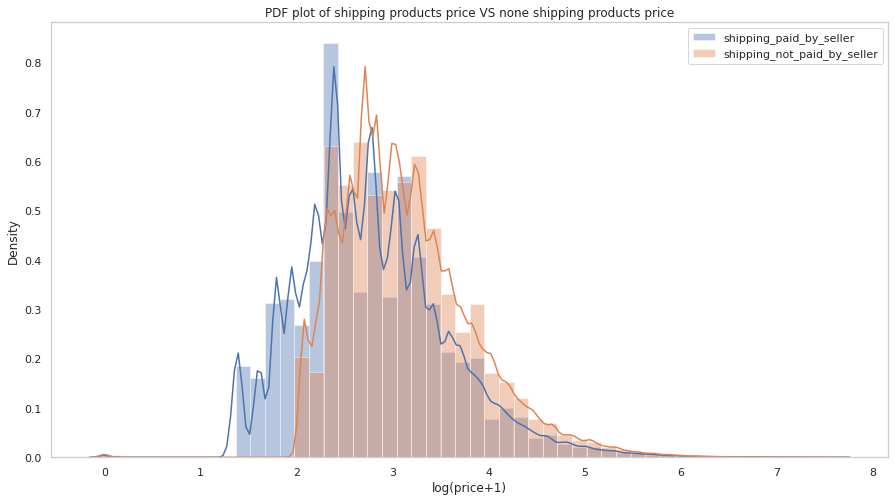

In [36]:
plt.figure(figsize=(15,8))
sns.distplot(shipping_paid_by_seller,label='shipping_paid_by_seller')
sns.distplot(shipping_not_paid_by_seller,label='shipping_not_paid_by_seller')
plt.title('PDF plot of shipping products price VS none shipping products price')
plt.xlabel("log(price+1)")
plt.grid()
plt.legend()
plt.show()

The average price of item for which the shipping is not paid by seller is higher than those whose shipping price is paid by the seller.It is actually inverse of the basic understanding that items which are high priced have high profit and sellers mange the shipping cost

##EDA on Category_name

    It shows the category of the item



In [37]:
train['category_name'].fillna('missing',inplace=True)
print('No of missing values in category_name: ',train['category_name'].isnull().sum())

No of missing values in category_name:  0


In [38]:
train['category_name'][1:10]

1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
5                                    Women/Other/Other
6                             Women/Swimwear/Two-Piece
7                      Sports & Outdoors/Apparel/Girls
8                      Sports & Outdoors/Apparel/Girls
9             Vintage & Collectibles/Collectibles/Doll
Name: category_name, dtype: object

we can see that it is in a hierarchical form of multiple subcategories.Lets seperate them into subcategories

In [39]:
train['main_category'],train['subcategory1'],train['subcategory2']=train['category_name'].str.split("/",2).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [40]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces
...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,Mid-Calf
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,Fitness accessories
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,Home Décor Accents


In [41]:
test['main_category'],test['subcategory1'],test['subcategory2']=test['category_name'].str.split("/",2).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


#EDA on main category

no of the unique categories:  ['Men' 'Electronics' 'Women' 'Home' 'Sports & Outdoors'
 'Vintage & Collectibles' 'Beauty' 'Other' 'Kids' 'missing' 'Handmade']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


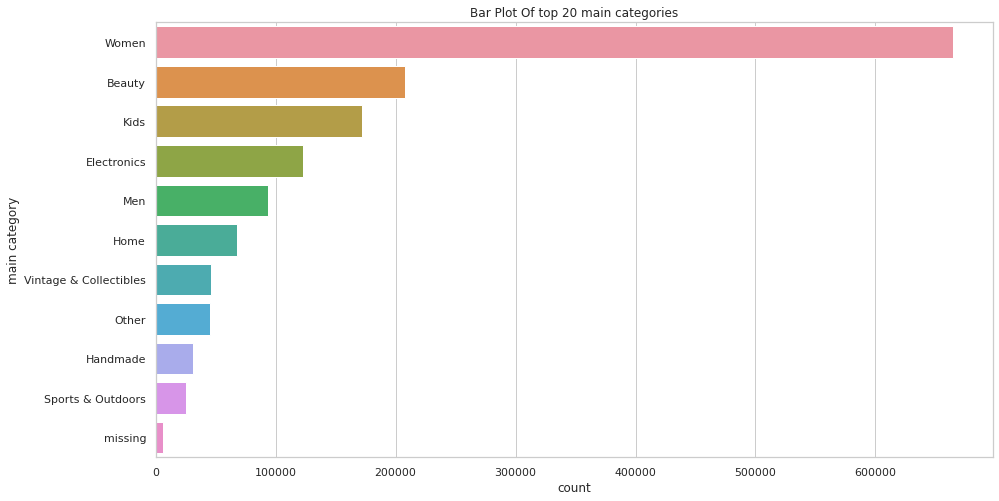

In [42]:
count=train['main_category'].value_counts()
print('no of the unique categories: ', train['main_category'].unique())
plt.figure(figsize=(15,8))
sns.barplot(count,count.index)
plt.title("Bar Plot Of top 20 main categories")
plt.xlabel('count')
plt.ylabel('main category')
plt.show()

There are 10 unique categories and 11th are the missing values.Top category is women,beauty which means that most of the products are for womem.Lets see how price changes wrt main category

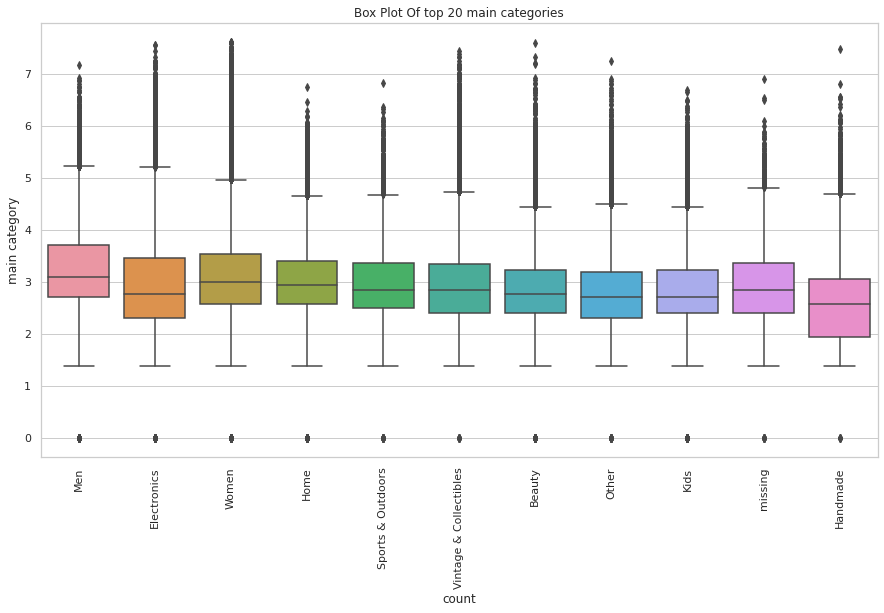

In [43]:
plt.figure(figsize=(15,8))
ax=sns.boxplot(x=train['main_category'],y=np.log(train['price']+1))
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.xticks(rotation=90)
plt.title("Box Plot Of top 20 main categories")
plt.xlabel('count')
plt.ylabel('main category')
plt.show()

There average prices are almost same.


#EDA on sub_category1


In [44]:
train.subcategory1.isnull().sum()

6327

In [45]:
train["subcategory1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub category1 : ", train.subcategory1.isnull().sum())

Number of Missing Values in sub category1 :  0


Number of unique sub categories1 114


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


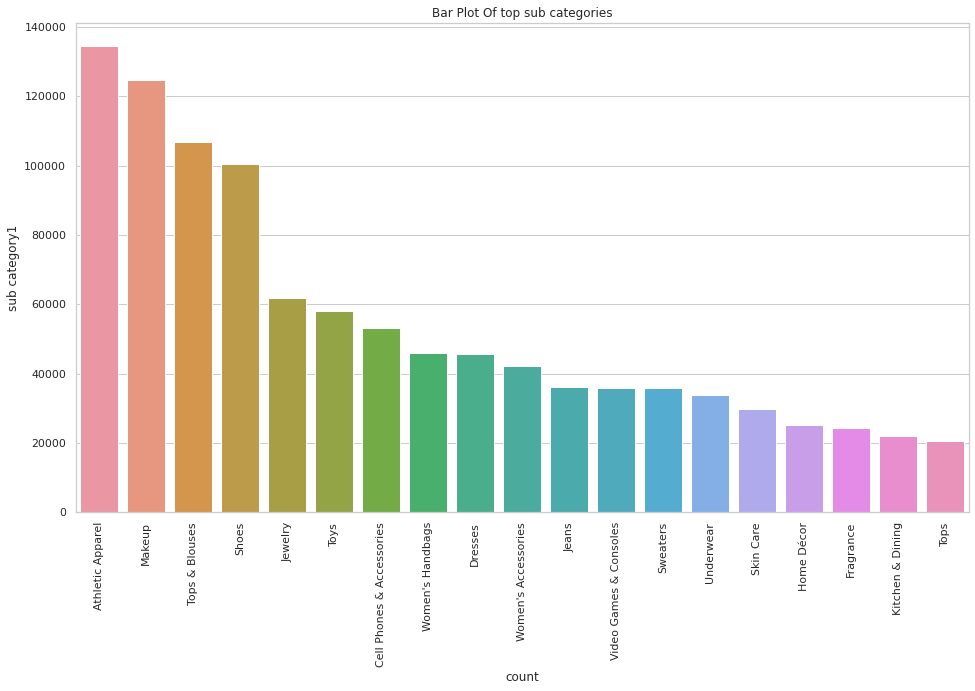

In [46]:
count=train['subcategory1'].value_counts()
print("Number of unique sub categories1",len(count))
plt.figure(figsize=(16,9))
sns.barplot(count.index[0:19],count[0:19])
plt.xticks(rotation=90)
plt.title("Bar Plot Of top sub categories")
plt.xlabel('count')
plt.ylabel('sub category1')
plt.show()

Most of the datapoints are of sub category athletic apparel,makeup etc.


Number of Missing Values in sub category2 :  0
Number of unique sub categories2:  872


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


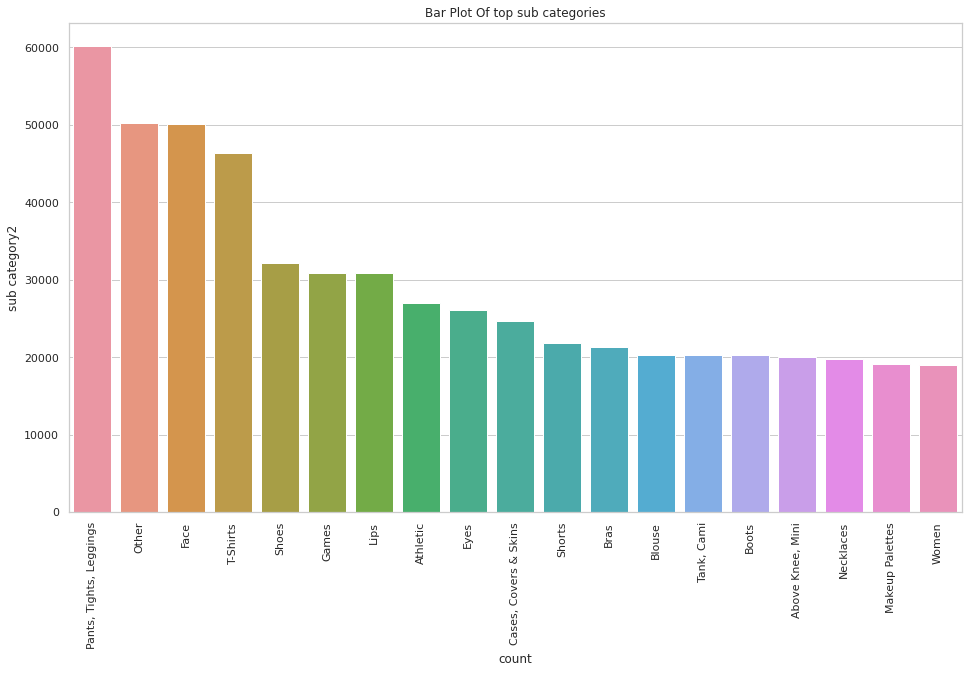

In [47]:
train["subcategory2"].fillna("missing", inplace=True)
print("Number of Missing Values in sub category2 : ", train.subcategory2.isnull().sum())
count=train['subcategory2'].value_counts()
print("Number of unique sub categories2: ",len(count))
plt.figure(figsize=(16,9))
sns.barplot(count.index[0:19],count[0:19])
plt.xticks(rotation=90)
plt.title("Bar Plot Of top sub categories")
plt.xlabel('count')
plt.ylabel('sub category2')
plt.show()

Most of the sub_category2 of the datapoints are pants,tights,leggings.Some features are have other as subcategory2 but there prior category are not strictly other

In [48]:
train['name'][0:20]

0        MLB Cincinnati Reds T Shirt Size XL
1           Razer BlackWidow Chroma Keyboard
2                             AVA-VIV Blouse
3                      Leather Horse Statues
4                       24K GOLD plated rose
5           Bundled items requested for Ruie
6         Acacia pacific tides santorini top
7       Girls cheer and tumbling bundle of 7
8                      Girls Nike Pro shorts
9     Porcelain clown doll checker pants VTG
10                           Smashbox primer
11                    New vs pi k body mists
12                        Black Skater dress
13                      Sharpener and eraser
14        HOLD for Dogs2016 Minnetonka boots
15               Sephora tarte birthday gift
16                         Glitter Eyeshadow
17       New: Baby K'tan active baby carrier
18       Too Faced Limited "Merry Macaroons"
19            Cream/ Beige Front Cross Shirt
Name: name, dtype: object

In [49]:
names_list=list(train['name'])
all_names=" ".join(names_list)

In [50]:
pip install wordcloud

In [51]:
from wordcloud import WordCloud

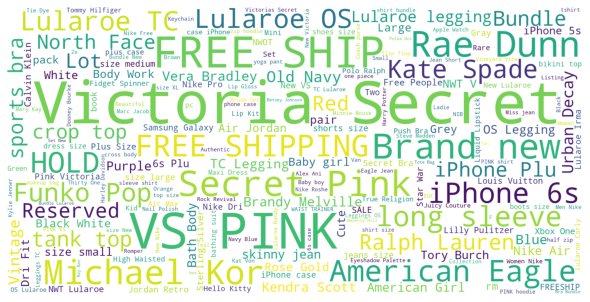

In [52]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/


wordcloud = WordCloud(width = 1600, height = 800,background_color ='white', min_font_size = 10).generate(all_names) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

There are few brands name which can be noticed. now lets check the item names for higher price products

In [53]:
names_high_prices= list(train['name'].loc[train['price']>29])
all_names=" ".join(names_high_prices)

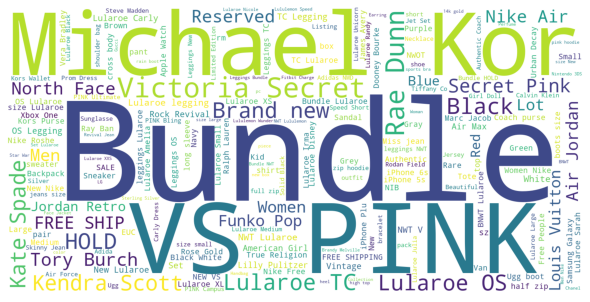

In [54]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/


wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_names) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

bundle word appears more often, may be products sold in higher price range are in bundle

##EDA on item_description

    4 items have missing descriptions
    Around 82000 item have description as "No description yet"

So lets convert missing values to no description yet.


In [55]:
train['item_description'].fillna("No description yet",inplace= True)
print("Number of Missing Values in item_description : ", train.item_description.isnull().sum())

Number of Missing Values in item_description :  0


In [56]:
description_list=list(train['item_description'])
all_descriptions=" ".join(description_list)

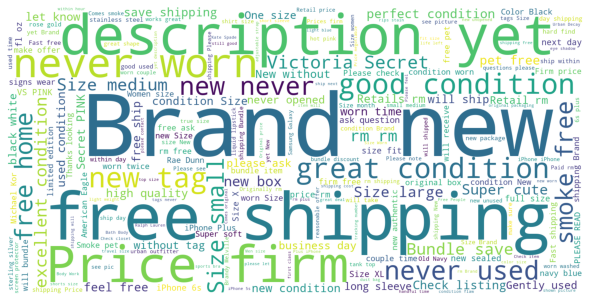

In [57]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_descriptions) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Most common words in the description appear to be **Brand, new ,free shipping** and since a large number of the rows dont have any description so **"description" ,"yet"** also appear in the word cloud

**lets now check for item description of items with high prices**

In [58]:
description_high_prices = list(train['item_description'].loc[train['price'] > 29])
all_descriptions=" ".join(description_high_prices)

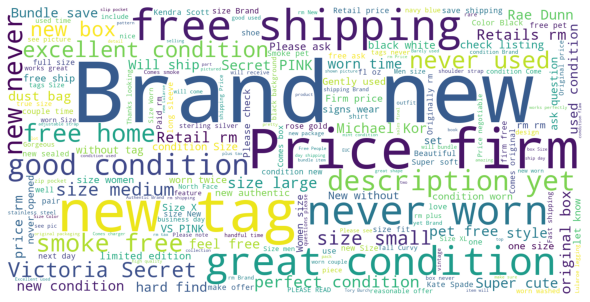

In [59]:
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_descriptions) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

##Sentiment Analysis of item_description

*   It is needed to be done before text preprocessing.
*   A sentiment value of "GOOD" is different from "good"



In [60]:
#https://github.com/oin156/Mercari-Price-Suggestion-Challenge/blob/master/MercariPrice.ipynb

sentiment_analyser=SentimentIntensityAnalyzer()

train_sentiment_description=[]
train_sentiment_name=[]

for descriptions in tqdm(train['item_description'].values):
    ss = sentiment_analyser.polarity_scores(descriptions)
    train_sentiment_description.append(ss)

for name in tqdm(train['name'].values):
    ss = sentiment_analyser.polarity_scores(name)
    train_sentiment_name.append(ss) 


100%|██████████| 1482535/1482535 [01:51<00:00, 13325.89it/s]


In [61]:
negative_description=[]
neutral_description=[]
positive_description=[]
compounding_description=[]
for i in train_sentiment_description: 
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative_description.append(score)
        if(polarity=='neu'):
            neutral_description.append(score)
        if(polarity=='pos'):
            positive_description.append(score)
        if(polarity=='compound'):
            compounding_description.append(score)

In [62]:
train['negative_description']=negative_description
train['neutral_description']=neutral_description
train['positive_description']=positive_description
train['compound_description']=compounding_description

In [63]:
negative_name=[]
neutral_name=[]
positive_name=[]
compounding_name=[]
for i in train_sentiment_name: 
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative_name.append(score)
        if(polarity=='neu'):
            neutral_name.append(score)
        if(polarity=='pos'):
            positive_name.append(score)
        if(polarity=='compound'):
            compounding_name.append(score)

In [64]:
train['negative_name']=negative_name
train['neutral_name']=neutral_name
train['positive_name']=positive_name
train['compound_name']=compounding_name

In [65]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000


##Count number of stopwords in description

1.   This also needs to be done before preprocessing as in preprocessing we would remove stopwords



In [66]:
all_stopwords= set(stopwords.words('english'))
def number_of_stopwords(data):
  """this function counts the number of stopwords in each of the item_description"""
  count_stopwords=[]
  for i in tqdm(data['item_description'].values):
    count=0
    for j in i.split(' '):
      if j in all_stopwords:
        count+=1
    count_stopwords.append(count)
  return count_stopwords

In [67]:
train['count_stopwords']=number_of_stopwords(train)
print(train['count_stopwords'])

100%|██████████| 1482535/1482535 [00:06<00:00, 225787.72it/s]


0           0
1          15
2          13
3          10
4           2
           ..
1482530     4
1482531     0
1482532     3
1482533    11
1482534     3
Name: count_stopwords, Length: 1482535, dtype: int64


##Data Preprocessing.

1.   Convert Price to log(price+1)
2.   Fill the missing values in all features with appropriate values.
3.   Drop duplicate values
4.   Text Preprocessing on item description and name
2.   List item





In [68]:
#because the allowed range for item prices at mercari is between 5 dollars to 2000 dollars
mask1 = (train['price']>5)
mask2 = (train['price']<=2000)
train_new=train[mask1]
train_new2=train_new[mask2]
train=train_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [69]:
train['price']=np.log(train['price']+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
train["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", train['category_name'].isnull().sum())

train['main_category'],train['subcategory1'],train['subcategory2']=train['category_name'].str.split("/",2).str

train["subcategory1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category1 : ", train['subcategory1'].isnull().sum())

train["subcategory2"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category2 : ", train['subcategory2'].isnull().sum())

train["brand_name"].fillna("missing", inplace=True)
print("Number of Missing Values in brand_name : ", train['brand_name'].isnull().sum())

train["item_description"].fillna("No description yet", inplace=True)
print("Number of Missing Values in item_description : ", train['item_description'].isnull().sum())

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Number of Missing Values in Category Name :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0
Number of Missing Values in item_description :  0


Doing same thing for test data also

In [72]:
test["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", test['category_name'].isnull().sum())

test['main_category'],test['subcategory1'],test['subcategory2']=test['category_name'].str.split("/",2).str

test["subcategory1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category1 : ", test['subcategory1'].isnull().sum())

test["subcategory2"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category2 : ", test['subcategory2'].isnull().sum())

test["brand_name"].fillna("missing", inplace=True)
print("Number of Missing Values in brand_name : ", test['brand_name'].isnull().sum())

test["item_description"].fillna("No description yet", inplace=True)
print("Number of Missing Values in item_description : ", test['item_description'].isnull().sum())

Number of Missing Values in Category Name :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.


Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0
Number of Missing Values in item_description :  0


In [73]:
a=0
missing_brand_indexes_before_filling = []
for i in list(train['brand_name']):
  if i=="missing":
    missing_brand_indexes_before_filling.append(a)
  a += 1



In [74]:
a=0
missing_brand_indexes_before_filling_test = []
for i in list(test['brand_name']):
  if i=="missing":
    missing_brand_indexes_before_filling_test.append(a)
  a += 1

print(len(missing_brand_indexes_before_filling_test))

1476490


In [75]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'missing']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'missing'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='missing':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('missing')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [76]:
train = brand_guesser(train)

100%|██████████| 1415314/1415314 [06:52<00:00, 3429.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
a=0
missing_brand_indexes_after_filling = []
for i in list(train['brand_name']):
  if i=="missing":
    missing_brand_indexes_after_filling.append(a)
  a += 1
a

1415314

In [78]:
indexes_filled = list(set(missing_brand_indexes_before_filling) - set(missing_brand_indexes_after_filling))
print(len(missing_brand_indexes_before_filling) , len(missing_brand_indexes_after_filling), len(indexes_filled ))

586955 496013 90942


In [79]:
indexes_filled = list(set(missing_brand_indexes_before_filling) - set(missing_brand_indexes_after_filling))
print(len(missing_brand_indexes_before_filling) , len(missing_brand_indexes_after_filling), len(indexes_filled ))

586955 496013 90942


In [80]:
train.iloc[indexes_filled[2]]

train_id                                                           274419
name                                    3D Fiber Lash Mascara by Younique
item_condition_id                                                       1
category_name                                          Beauty/Makeup/Eyes
brand_name                                                       Younique
price                                                             2.77259
shipping                                                                1
item_description        Brand New 2 Piece Mascara Box - Black Color Po...
main_category                                                      Beauty
subcategory1                                                       Makeup
subcategory2                                                         Eyes
negative_description                                                    0
neutral_description                                                     1
positive_description                  

In [81]:
train.shape

(1415314, 20)

In [82]:
test = brand_guesser(test)

100%|██████████| 3460725/3460725 [17:11<00:00, 3356.04it/s]


In [83]:
a=0
missing_brand_indexes_after_filling_test=[]
for i in list(test['brand_name']):
  if i=="missing":
    missing_brand_indexes_after_filling_test.append(a)
  a += 1

print(len(missing_brand_indexes_after_filling_test))

1233564


In [84]:
indexes_filled_test = list(set(missing_brand_indexes_before_filling_test) - set(missing_brand_indexes_after_filling_test))
print(len(missing_brand_indexes_before_filling_test) , len(missing_brand_indexes_after_filling_test), len(indexes_filled_test ))

1476490 1233564 242926


In [85]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,2.397895,1,No description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.0,0.0,0.0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.0,0.0,0.0,15
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.0,0.0,0.0,13
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.0,0.0,0.0,10
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,2


In [86]:
all_stopwords=set(stopwords.words('english'))

In [87]:
# https://stackoverflow.com/a/47091490/4084039
#applied ai course


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [88]:
# https://gist.github.com/sebleier/554280
def text_preprocessing(data):
  """this function performs preprocessing the item_description """
  preprocessed_total = []
  for sentance in tqdm(data):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in all_stopwords) #removing stop words
    preprocessed_total.append(sent.lower().strip())
  return preprocessed_total


In [89]:
preprocessed__descriptions=text_preprocessing(train['item_description'])

100%|██████████| 1415314/1415314 [00:41<00:00, 33956.02it/s]


In [90]:
train['item_description']=preprocessed__descriptions
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000,15
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000,13
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000,10
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,3.044522,1,lace says size small fits medium perfectly nev...,Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579,4
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,2.708050,0,little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000,0
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,2.564949,0,used twice still great shape,Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000,3
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,3.828641,1,2 one see 2 red 2 orange 2 big red orange ones...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,11


In [91]:
preprocessed_name=text_preprocessing(train['name'])

100%|██████████| 1415314/1415314 [00:23<00:00, 60657.84it/s]


In [92]:
train['name']=preprocessed_name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
preprocessed__descriptions=text_preprocessing(test['item_description'])
test['item_description']=preprocessed__descriptions

preprocessed_name=text_preprocessing(test['name'])
test['name']=preprocessed_name

100%|██████████| 3460725/3460725 [00:57<00:00, 60356.19it/s]


# Feature Engineering

1.   length of text features ie name and item_description
2.   if item is branded or not





## 1.Length of text features

In [94]:
def text_feature_length(data):
  """This function computes the length of text features"""
  list_of_length=[]
  for sentence in tqdm(data):
      length_value=len(sentence.split(" "))
      list_of_length.append(length_value)
  return list_of_length

In [95]:
train['description_length']=text_feature_length(train['item_description'])
train['name_length']=text_feature_length(train['name'])

100%|██████████| 1415314/1415314 [00:01<00:00, 751416.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 1415314/1415314 [00:01<00:00, 1297278.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


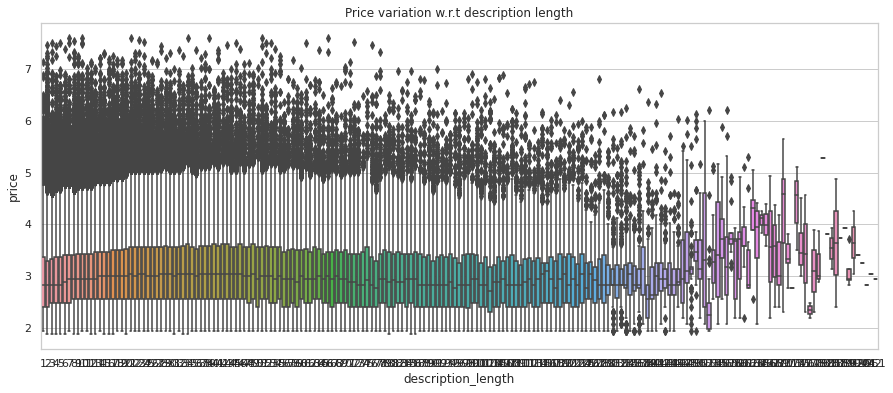

In [96]:
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(x=train['description_length'], y=train['price'])
plt.title('Price variation w.r.t description length')
plt.show()

We can see that as mean prices do not change much with description length but most of the high priced item have small description length.

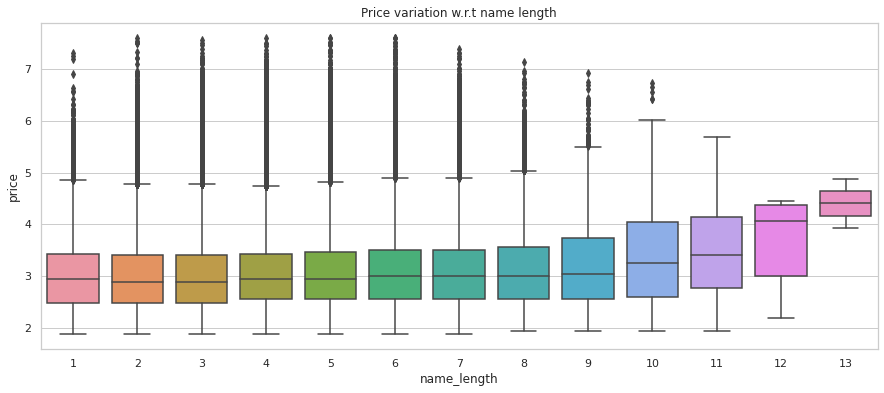

In [97]:
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(x=train['name_length'], y=train['price'])
plt.title('Price variation w.r.t name length')
plt.show()

We can see that means prices increase slightly for long name lenght.

#2.If branded or not

1.     0 if brand_name is nnot present
2.     1 if brand_name is present


In [98]:
def branded_or_not(data):
  brand_known_or_not=[]
  """This function checks if brand name is missing or not"""
  for brands in tqdm(data):
    if brands=="missing":
      brand_known_or_not.append(0)
    else:
      brand_known_or_not.append(1)
  return brand_known_or_not


In [99]:
train['brand_known_or_not']=branded_or_not(train['brand_name'])
train

100%|██████████| 1415314/1415314 [00:00<00:00, 2289359.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,description_length,name_length,brand_known_or_not
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000,0,2,6,1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000,15,18,4,1
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000,13,14,3,1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000,10,18,3,0
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,2,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,Women/Dresses/Mid-Calf,Free People,3.044522,1,lace says size small fits medium perfectly nev...,Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579,4,16,4,1
1482531,1482531,little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,2.708050,0,little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000,0,8,4,1
1482532,1482532,21 day fix containers eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,2.564949,0,used twice still great shape,Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000,3,5,6,0
1482533,1482533,world markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,3.828641,1,2 one see 2 red 2 orange 2 big red orange ones...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,11,14,3,0


We had seen tha price depends a lot on brand so one feature could be the average price of the items brand.

On Grouping Category Name, Brand Name and Shipping we will create 8 new features
with respect to Price like Price_Mean, Price_Median, Price_Std_Deviation, Minimum and
Maximum Price per group

In [100]:
train['cat_brand_ship'] = (train['main_category'].astype(str) + "/" + 
                          train['subcategory1'].astype(str) + "/" +
                          train['subcategory2'].astype(str) + "_" +
                          train['brand_name'].astype(str) + "_" +  
                          train['shipping'].astype(str))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [101]:
test['cat_brand_ship'] = (test['main_category'].astype(str) + "/" + 
                          test['subcategory1'].astype(str) + "/" +
                          test['subcategory2'].astype(str) + "_" +
                          test['brand_name'].astype(str) + "_" +  
                          test['shipping'].astype(str))

In [102]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,description_length,name_length,brand_known_or_not,cat_brand_ship
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.0,0.0,0.0,0,2,6,1,Men/Tops/T-shirts_MLB_1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.0,0.0,0.0,15,18,4,1,Electronics/Computers & Tablets/Components & P...
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.0,0.0,0.0,13,14,3,1,Women/Tops & Blouses/Blouse_Target_1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.0,0.0,0.0,10,18,3,0,Home/Home Décor/Home Décor Accents_missing_1
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,2,3,4,0,Women/Jewelry/Necklaces_missing_0


In [103]:
new_df = train[['price','name_length','negative_description','neutral_description','positive_description','compound_description','negative_name','neutral_name','positive_name','compound_name','count_stopwords','description_length','name_length','brand_known_or_not']]

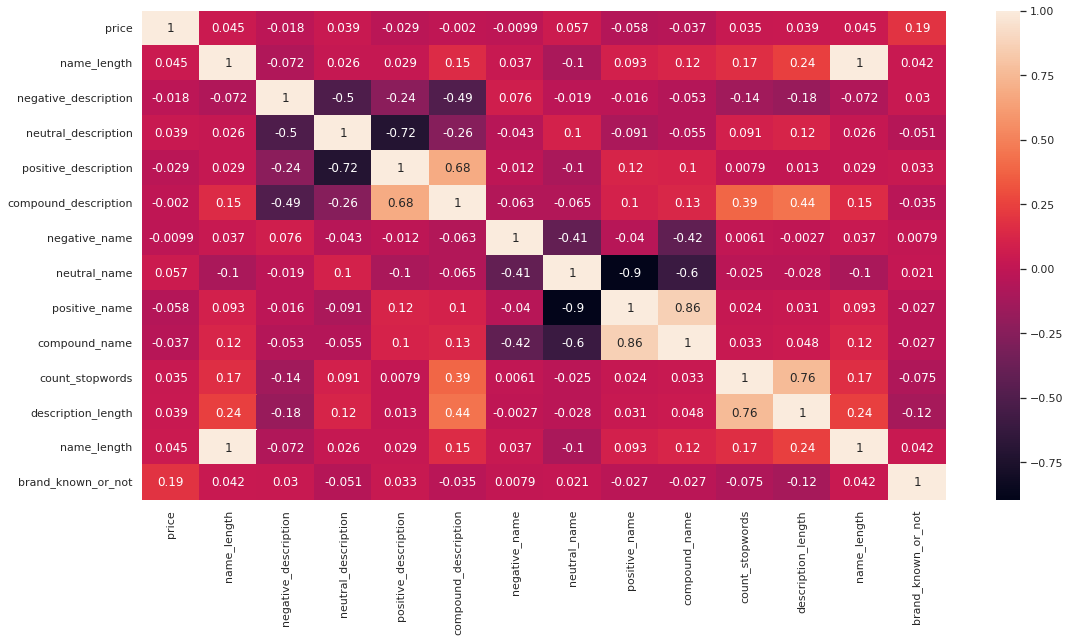

In [104]:
correlation_matrix = new_df.corr()
plt.figure(figsize = (18,9))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [105]:
train.drop(['name_length','negative_description','neutral_description','positive_description','compound_description','negative_name','neutral_name','positive_name','compound_name','count_stopwords','description_length','name_length'],axis = 1, inplace = True)
train.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1415314, 13)

In [106]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,brand_known_or_not,cat_brand_ship
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,1,Men/Tops/T-shirts_MLB_1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,1,Electronics/Computers & Tablets/Components & P...
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,1,Women/Tops & Blouses/Blouse_Target_1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0,Home/Home Décor/Home Décor Accents_missing_1
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0,Women/Jewelry/Necklaces_missing_0


In [107]:
test['brand_known_or_not']=branded_or_not(test['brand_name'])
test.shape

100%|██████████| 3460725/3460725 [00:01<00:00, 2347101.18it/s]


(3460725, 12)

In [108]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,subcategory1,subcategory2,cat_brand_ship,brand_known_or_not
0,0,breast cancer fight like girl ring,1,Women/Jewelry/Rings,missing,1,size 7,Women,Jewelry,Rings,Women/Jewelry/Rings_missing_1,0
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,missing,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,Other/Office supplies/Shipping Supplies_missing_1,0
2,2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag bought rm coach outlet,Vintage & Collectibles,Bags and Purses,Handbag,Vintage & Collectibles/Bags and Purses/Handbag...,1
3,3,floral kimono,2,Women/Sweaters/Cardigan,missing,0,floral kimono never worn lightweight perfect h...,Women,Sweaters,Cardigan,Women/Sweaters/Cardigan_missing_0,0
4,4,life death,3,Other/Books/Religion & Spirituality,missing,1,rediscovering life loss loved one tony cooke p...,Other,Books,Religion & Spirituality,Other/Books/Religion & Spirituality_missing_1,0


In [109]:
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_count',
                                                              'cbs_log_price_mean',
                                                              'cbs_log_price_std',
                                                              'cbs_log_price_conf_variance',
                                                              'cbs_min_expected_log_price',
                                                              'cbs_max_expected_log_price',
                                                              'cbs_log_price_min',
                                                              'cbs_log_price_max']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [110]:

train_cbs_features = generate_cbs_stats(train,train)
test_cbs_features = generate_cbs_stats(train,test)
print("New Train CBS Features Shape : ", train_cbs_features.shape)
print("New Test CBS Features Shape : ", test_cbs_features.shape)

New Train CBS Features Shape :  (1415314, 8)
New Test CBS Features Shape :  (3460725, 8)


In [111]:
train_data=train.copy()
test_data= test.copy()

In [112]:
train_cbs_features[:10]

array([[-1.76280790e+00, -1.08222953e+00, -1.56658904e+00,
        -1.41333286e+00,  3.12736734e-03, -1.51429359e+00,
         2.66786663e-01, -2.00558467e+00],
       [-1.45675235e+00,  1.60936961e+00, -3.31152712e-01,
        -9.86284272e-01,  1.92986374e+00,  9.63748831e-01,
         2.54127883e+00, -5.83335339e-01],
       [-1.58584847e+00, -1.28332561e+00, -1.29561380e+00,
        -9.58296389e-01, -4.05168921e-01, -1.52356595e+00,
        -1.54441832e-01, -1.86641435e+00],
       [ 8.43333112e-01, -9.02735012e-01,  9.17781557e-03,
         5.61364336e-01, -9.55066430e-01, -6.26072568e-01,
        -6.31991314e-01,  2.33681115e-01],
       [ 1.07799614e+00, -3.88261882e-01,  1.13526301e+00,
         1.55871264e+00, -1.23437137e+00,  2.78416605e-01,
        -8.97024300e-01,  1.49250513e+00],
       [ 8.22190186e-01,  1.41875840e-01,  1.10250843e+00,
         1.12300600e+00, -6.53982422e-01,  6.32834546e-01,
        -1.54441832e-01,  1.40039577e+00],
       [-1.92868743e-01,  2.055737

In [113]:
train_data['cbs_log_count']=train_cbs_features[:,0]
train_data['cbs_log_price_mean']=train_cbs_features[:,1]
train_data['cbs_log_price_std']=train_cbs_features[:,2]
train_data['cbs_log_price_conf_variance']=train_cbs_features[:,3]
train_data['cbs_min_expected_log_price']=train_cbs_features[:,4]
train_data['cbs_max_expected_log_price']=train_cbs_features[:,5]
train_data['cbs_log_price_min']=train_cbs_features[:,6]
train_data['cbs_log_price_max']=train_cbs_features[:,7]

In [114]:
train_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,brand_known_or_not,cat_brand_ship,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,1,Men/Tops/T-shirts_MLB_1,-1.762808,-1.082230,-1.566589,-1.413333,0.003127,-1.514294,0.266787,-2.005585
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,1,Electronics/Computers & Tablets/Components & P...,-1.456752,1.609370,-0.331153,-0.986284,1.929864,0.963749,2.541279,-0.583335
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,1,Women/Tops & Blouses/Blouse_Target_1,-1.585848,-1.283326,-1.295614,-0.958296,-0.405169,-1.523566,-0.154442,-1.866414
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0,Home/Home Décor/Home Décor Accents_missing_1,0.843333,-0.902735,0.009178,0.561364,-0.955066,-0.626073,-0.631991,0.233681
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0,Women/Jewelry/Necklaces_missing_0,1.077996,-0.388262,1.135263,1.558713,-1.234371,0.278417,-0.897024,1.492505


In [115]:
test_data['cbs_log_count']=test_cbs_features[:,0]
test_data['cbs_log_price_mean']=test_cbs_features[:,1]
test_data['cbs_log_price_std']=test_cbs_features[:,2]
test_data['cbs_log_price_conf_variance']=test_cbs_features[:,3]
test_data['cbs_min_expected_log_price']=test_cbs_features[:,4]
test_data['cbs_max_expected_log_price']=test_cbs_features[:,5]
test_data['cbs_log_price_min']=test_cbs_features[:,6]
test_data['cbs_log_price_max']=test_cbs_features[:,7]

In [116]:
test_data.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,subcategory1,subcategory2,cat_brand_ship,brand_known_or_not,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
0,0,breast cancer fight like girl ring,1,Women/Jewelry/Rings,missing,1,size 7,Women,Jewelry,Rings,Women/Jewelry/Rings_missing_1,0,0.890876,-0.131891,1.979280,2.477198,-1.422605,0.636034,-0.220474,1.901619
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,missing,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,Other/Office supplies/Shipping Supplies_missing_1,0,1.072628,-0.730578,-0.516980,0.038683,-0.587750,-0.724766,-0.220474,0.389778
2,2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag bought rm coach outlet,Vintage & Collectibles,Bags and Purses,Handbag,Vintage & Collectibles/Bags and Purses/Handbag...,1,-0.798625,0.991601,0.970294,0.372768,0.626062,1.083099,0.082541,0.270359
3,3,floral kimono,2,Women/Sweaters/Cardigan,missing,0,floral kimono never worn lightweight perfect h...,Women,Sweaters,Cardigan,Women/Sweaters/Cardigan_missing_0,0,0.684920,0.103473,1.335333,1.472611,-0.718739,0.569638,0.082541,0.634662
4,4,life death,3,Other/Books/Religion & Spirituality,missing,1,rediscovering life loss loved one tony cooke p...,Other,Books,Religion & Spirituality,Other/Books/Religion & Spirituality_missing_1,0,-0.384375,-0.641630,-0.219018,0.356033,-0.665486,-0.549567,-0.220474,-0.453156


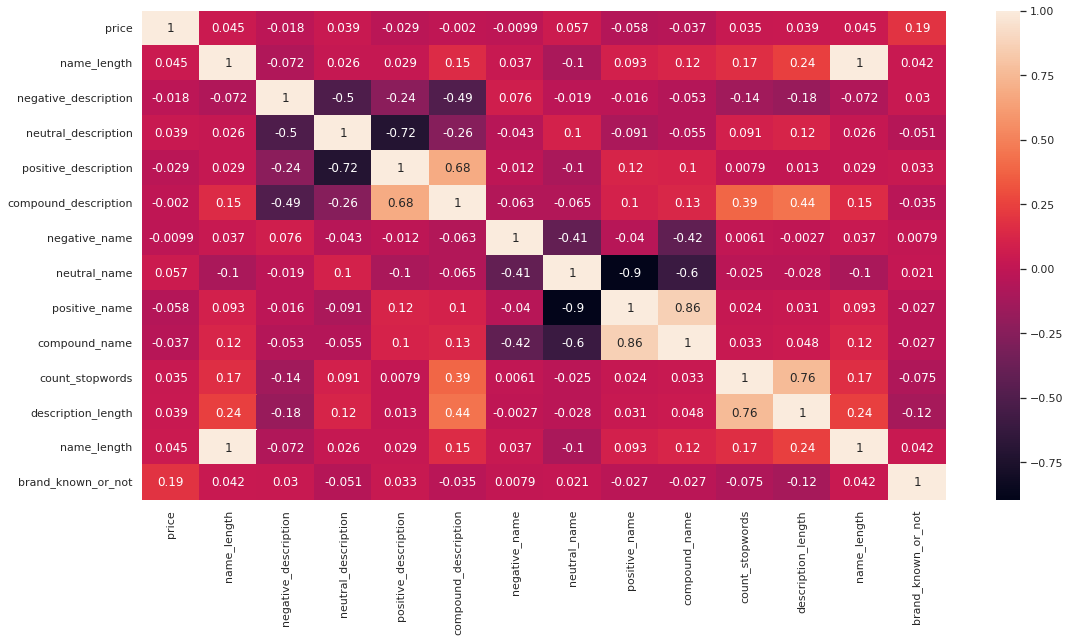

In [117]:

correlation_matrix = new_df.corr()
plt.figure(figsize = (18,9))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

By observing the last column we notice following features have high correlation with price:

*   cbs_log_price_mean
*   cbs_log_price_std
*   cbs_min_expected_log_price
*   cbs_max_expected_log_price
*   cbs_log_price_max
*   cbs_log_price_min

We will drop all other features

In [118]:
# Dropping  columns that have low correlation score from training and test data
train_data.drop(['category_name',
                'cat_brand_ship',
                'cbs_log_count',
                'cbs_log_price_conf_variance'],axis = 1, inplace = True)


test_data.drop(['category_name',
                'cat_brand_ship',
                'cbs_log_count',
                'cbs_log_price_conf_variance'],
                axis = 1, inplace = True)

In [119]:
print(train_data.shape,test_data.shape)
train_data.head(5)

(1415314, 17) (3460725, 16)


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_category,subcategory1,subcategory2,brand_known_or_not,cbs_log_price_mean,cbs_log_price_std,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
0,0,mlb cincinnati reds shirt size xl,3,MLB,2.397895,1,description yet,Men,Tops,T-shirts,1,-1.082230,-1.566589,0.003127,-1.514294,0.266787,-2.005585
1,1,razer blackwidow chroma keyboard,3,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,1,1.609370,-0.331153,1.929864,0.963749,2.541279,-0.583335
2,2,ava viv blouse,1,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,1,-1.283326,-1.295614,-0.405169,-1.523566,-0.154442,-1.866414
3,3,leather horse statues,1,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0,-0.902735,0.009178,-0.955066,-0.626073,-0.631991,0.233681
4,4,24k gold plated rose,1,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0,-0.388262,1.135263,-1.234371,0.278417,-0.897024,1.492505


In [120]:
print(test_data.shape)
test_data.head(5)

(3460725, 16)


,test_id,name,item_condition_id,brand_name,shipping,item_description,main_category,subcategory1,subcategory2,brand_known_or_not,cbs_log_price_mean,cbs_log_price_std,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
0,0,breast cancer fight like girl ring,1,missing,1,size 7,Women,Jewelry,Rings,0,-0.131891,1.979280,-1.422605,0.636034,-0.220474,1.901619
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,missing,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,0,-0.730578,-0.516980,-0.587750,-0.724766,-0.220474,0.389778
2,2,coach bag,1,Coach,1,brand new coach bag bought rm coach outlet,Vintage & Collectibles,Bags and Purses,Handbag,1,0.991601,0.970294,0.626062,1.083099,0.082541,0.270359
3,3,floral kimono,2,missing,0,floral kimono never worn lightweight perfect h...,Women,Sweaters,Cardigan,0,0.103473,1.335333,-0.718739,0.569638,0.082541,0.634662
4,4,life death,3,missing,1,rediscovering life loss loved one tony cooke p...,Other,Books,Religion & Spirituality,0,-0.641630,-0.219018,-0.665486,-0.549567,-0.220474,-0.453156


In [121]:
train_data.to_csv("train_processed.csv")


In [122]:
# STORING THE CSV FILE 
test_data.to_csv("test_processed.csv")